In [ ]:
#import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

import warnings
# Suppressing the  warnings
warnings.filterwarnings("ignore")

Load datasets

In [241]:
# Load datasets
pizza_sales = pd.read_csv("Pizza_Sale.csv")
pizza_ingredients = pd.read_csv("Pizza_ingredients.csv")

Clean and preprocess the data

In [242]:
# Clean and preprocess the data
replace_with = pizza_sales[['pizza_name_id', 'pizza_category', 'pizza_ingredients', 'pizza_name']].mode().iloc[0]
pizza_sales[['pizza_name_id', 'pizza_category', 'pizza_ingredients', 'pizza_name']] = pizza_sales[[
    'pizza_name_id', 'pizza_category', 'pizza_ingredients', 'pizza_name']].fillna(replace_with)

pizza_sales['total_price'] = pizza_sales['total_price'].interpolate(method='linear')

In [243]:
# standardize datatype

pizza_sales['order_date'] = pd.to_datetime(pizza_sales['order_date'], format='%d-%m-%Y', errors='coerce')
pizza_sales = pizza_sales[pizza_sales['order_date'].notna()]

In [244]:
# Outlier: Z-score method/trimming delete outlier
upper_limit = pizza_sales['total_price'].mean() + 3 * pizza_sales['total_price'].std()
lower_limit = pizza_sales['total_price'].mean() - 3 * pizza_sales['total_price'].std()
pizza_sales = pizza_sales[(pizza_sales['total_price'] <= upper_limit) & (pizza_sales['total_price'] >= lower_limit)]



In [245]:
pizza_ingredients.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [ ]:
#missing values fill with mean
mean_qty = pizza_ingredients.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()
pizza_ingredients['Items_Qty_In_Grams'] = pizza_ingredients['Items_Qty_In_Grams'].fillna(
    pizza_ingredients['pizza_name_id'].map(mean_qty))

In [247]:
# Group by 'order_date' to get daily sales
daily_sales = pizza_sales.groupby('order_date')['total_price'].sum().reset_index()
daily_sales.rename(columns={'total_price': 'daily_sales'}, inplace=True)

Feature Engineering

In [248]:
# Feature Engineering: Adding holidays
calendar = USFederalHolidayCalendar()
holidays_list = calendar.holidays(start=daily_sales['order_date'].min(), end=daily_sales['order_date'].max())
daily_sales['is_holiday'] = daily_sales['order_date'].isin(holidays_list).astype(int)



In [249]:

# Lag Features: Adding lag 1 and lag 7 features
daily_sales['lag_1'] = daily_sales['daily_sales'].shift(1)
daily_sales['lag_7'] = daily_sales['daily_sales'].shift(7)

# Drop missing values from lag columns
daily_sales.dropna(inplace=True)


Exploratory Data Analysis (EDA)

Sales Trends Analysis

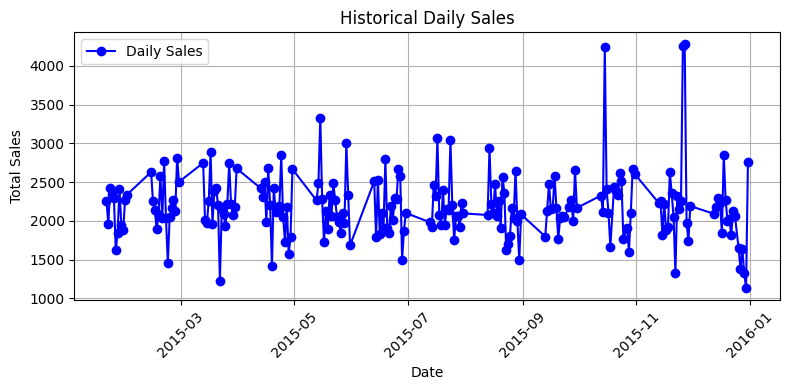

In [250]:
#EDA

import pandas as pd
import matplotlib.pyplot as plt

# Plot historical daily sales data
plt.figure(figsize=(8, 4))
plt.plot(pd.to_datetime(daily_sales['order_date']), daily_sales['daily_sales'], marker='o', color='b', linestyle='-', label='Daily Sales')
plt.title('Historical Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Rolling Averages

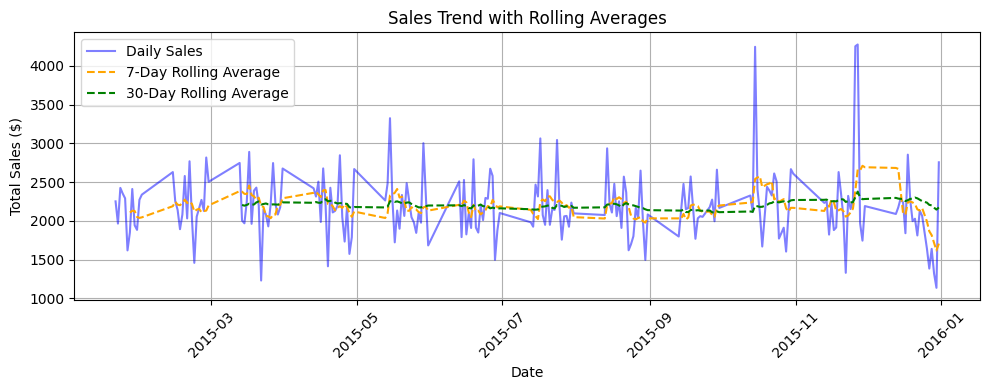

In [ ]:
# Step 1: Calculate 7-day and 30-day rolling averages
daily_sales_7day = daily_sales['daily_sales'].rolling(window=7).mean()
daily_sales_30day = daily_sales['daily_sales'].rolling(window=30).mean()

# Step 2: Plot daily sales and rolling averages
plt.figure(figsize=(10, 4))

# Plot daily sales
plt.plot(pd.to_datetime(daily_sales['order_date']), daily_sales['daily_sales'], label='Daily Sales', color='blue', alpha=0.5)

# Plot 7-day rolling average
plt.plot(pd.to_datetime(daily_sales['order_date']), daily_sales_7day, label='7-Day Rolling Average', color='orange', linestyle='--')

# Plot 30-day rolling average
plt.plot(pd.to_datetime(daily_sales['order_date']), daily_sales_30day, label='30-Day Rolling Average', color='green', linestyle='--')

# Adding titles and labels
plt.title('Sales Trend with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.legend()

# Formatting the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.tight_layout()
plt.show()


Seasonality and Patterns

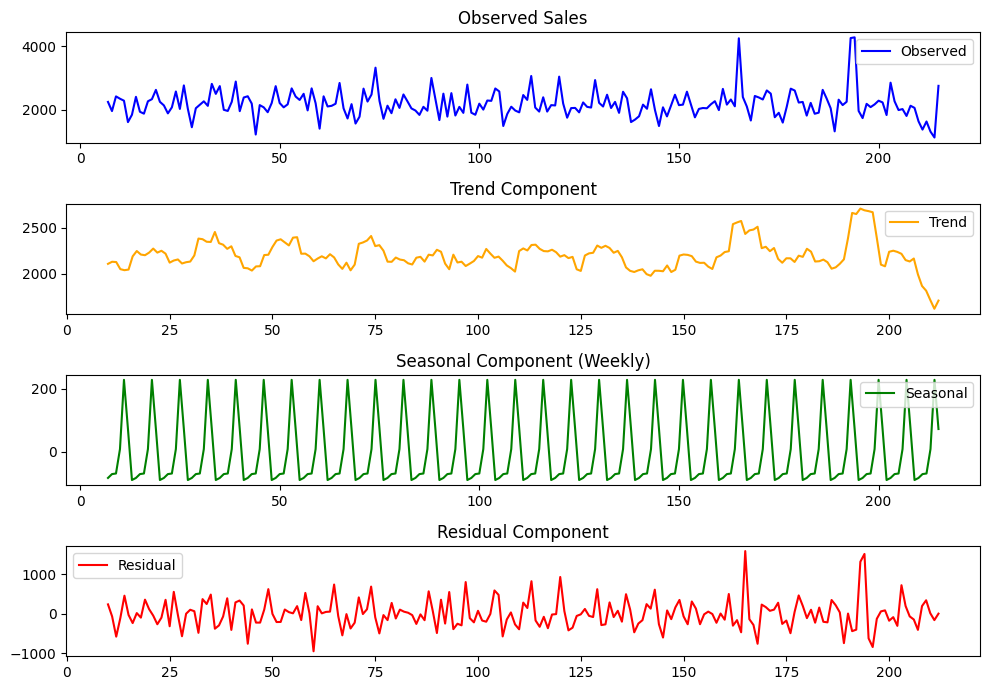

In [252]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Decompose the time series (daily_sales['daily_sales']) to observe trend, seasonality, and residuals

# Decompose the 'daily_sales' time series (you can adjust the period depending on the frequency of data)
decomposition = seasonal_decompose(daily_sales['daily_sales'], model='additive', period=7)

# Step 2: Plot decomposition
plt.figure(figsize=(10, 7))

# Plot Observed Sales
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.title('Observed Sales')
plt.legend()

# Plot Trend Component
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

# Plot Seasonal Component (Weekly)
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component (Weekly)')
plt.legend()

# Plot Residual Component
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()


Identifying Patterns in Features

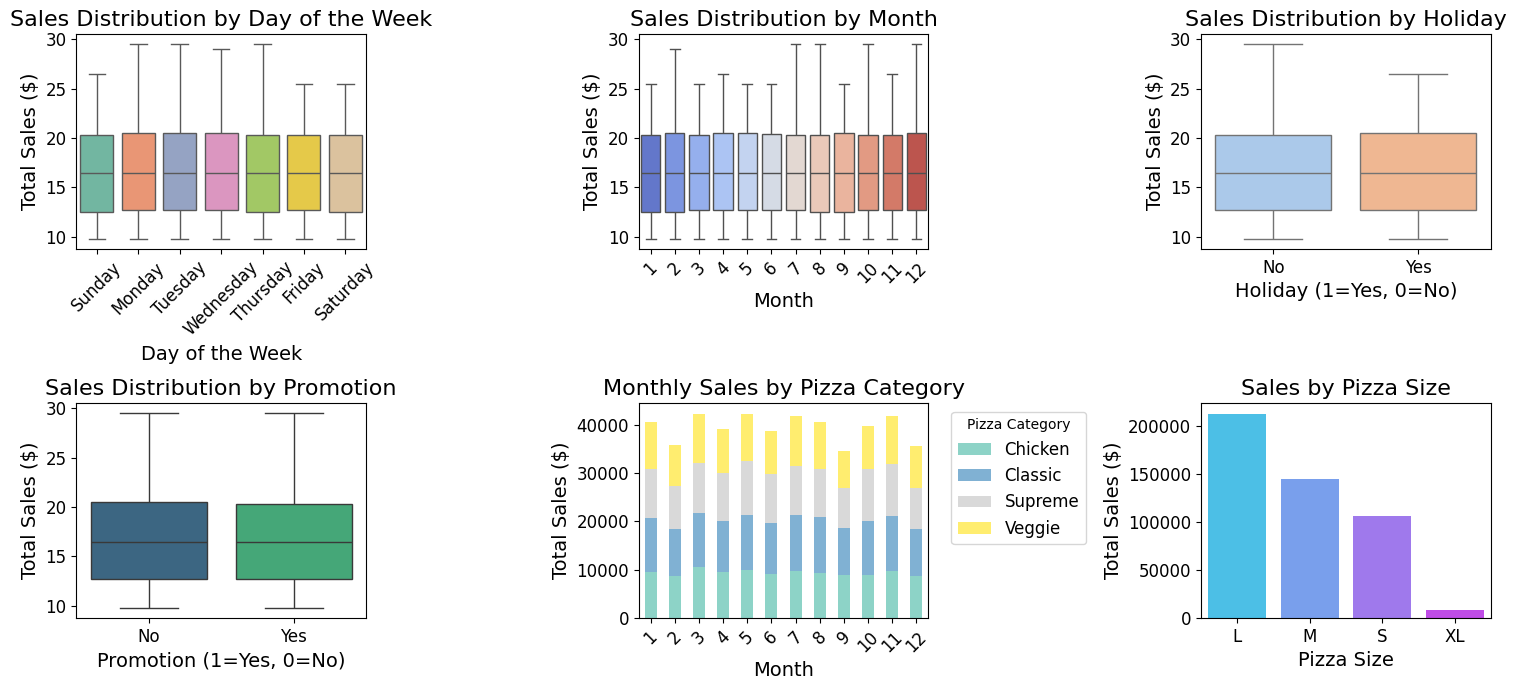

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

# Convert 'order_date' to datetime format
pizza_sales['order_date'] = pd.to_datetime(pizza_sales['order_date'])

# Create a new DataFrame for merging with holiday information to avoid modifying the original pizza_sales
pizza_sales_with_holiday = pizza_sales.copy()

# Create 'is_holiday' column by checking if 'order_date' is a holiday
calendar = USFederalHolidayCalendar()
holidays_list = calendar.holidays(start=pizza_sales['order_date'].min(), end=pizza_sales['order_date'].max())
pizza_sales_with_holiday['is_holiday'] = pizza_sales_with_holiday['order_date'].isin(holidays_list).astype(int)

# Create 'month' column (1 to 12)
pizza_sales_with_holiday['month'] = pizza_sales_with_holiday['order_date'].dt.month

# Create 'promotion_flag' column based on the 'month' (promotion in July, month == 7)
pizza_sales_with_holiday['promotion_flag'] = pizza_sales_with_holiday['month'].apply(lambda x: 1 if x == 7 else 0)

# Create the figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 14))  # Increased overall figure size

# Plot Sales Distribution by Day of the Week dynamically
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.boxplot(x=pizza_sales_with_holiday['order_date'].dt.day_name(), y='total_price', data=pizza_sales_with_holiday, palette='Set2', ax=axes[0, 0], order=day_order)
axes[0, 0].set_title('Sales Distribution by Day of the Week', fontsize=16)
axes[0, 0].set_xlabel('Day of the Week', fontsize=14)
axes[0, 0].set_ylabel('Total Sales ($)', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0, 0].tick_params(axis='y', labelsize=12)

# Plot Sales Distribution by Month (Ensuring 'month' is ordered from 1 to 12)
pizza_sales_with_holiday['month'] = pd.Categorical(pizza_sales_with_holiday['month'], categories=range(1, 13), ordered=True)
sns.boxplot(x='month', y='total_price', data=pizza_sales_with_holiday, palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Sales Distribution by Month', fontsize=16)
axes[0, 1].set_xlabel('Month', fontsize=14)
axes[0, 1].set_ylabel('Total Sales ($)', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[0, 1].tick_params(axis='y', labelsize=12)

# Plot Sales Distribution by Holiday
sns.boxplot(x='is_holiday', y='total_price', data=pizza_sales_with_holiday, palette='pastel', ax=axes[0, 2])
axes[0, 2].set_title('Sales Distribution by Holiday', fontsize=16)
axes[0, 2].set_xlabel('Holiday (1=Yes, 0=No)', fontsize=14)
axes[0, 2].set_ylabel('Total Sales ($)', fontsize=14)
axes[0, 2].set_xticklabels(['No', 'Yes'], fontsize=12)
axes[0, 2].tick_params(axis='y', labelsize=12)

# Plot Sales Distribution by Promotion using 'promotion_flag' column
sns.boxplot(x='promotion_flag', y='total_price', data=pizza_sales_with_holiday, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Sales Distribution by Promotion', fontsize=16)
axes[1, 0].set_xlabel('Promotion (1=Yes, 0=No)', fontsize=14)
axes[1, 0].set_ylabel('Total Sales ($)', fontsize=14)
axes[1, 0].set_xticklabels(['No', 'Yes'], fontsize=12)
axes[1, 0].tick_params(axis='y', labelsize=12)

# Stacked bar plot showing monthly sales by pizza category
sales_by_month_category = pizza_sales_with_holiday.groupby(['month', 'pizza_category']).agg({'total_price': 'sum'}).reset_index()
sales_by_month_category_pivot = sales_by_month_category.pivot_table(index='month', columns='pizza_category', values='total_price', aggfunc='sum')

# Plot Stacked Bar Plot for Monthly Sales by Pizza Category
sales_by_month_category_pivot.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='Set3', figsize=(15, 7))  # Increased size
axes[1, 1].set_title('Monthly Sales by Pizza Category', fontsize=16)
axes[1, 1].set_xlabel('Month', fontsize=14)
axes[1, 1].set_ylabel('Total Sales ($)', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1, 1].tick_params(axis='y', labelsize=12)

# Adding a legend with a title and adjusting its location
axes[1, 1].legend(title='Pizza Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Sales by Pizza Size
size_sales = pizza_sales_with_holiday.groupby('pizza_size').agg({'total_price': 'sum'}).reset_index()
size_sales = size_sales.sort_values('total_price', ascending=False)  # Sort by sales

# Plot Sales by Pizza Size
sns.barplot(x='pizza_size', y='total_price', data=size_sales, palette='cool', ax=axes[1, 2])
axes[1, 2].set_title('Sales by Pizza Size', fontsize=16)
axes[1, 2].set_xlabel('Pizza Size', fontsize=14)
axes[1, 2].set_ylabel('Total Sales ($)', fontsize=14)
axes[1, 2].tick_params(axis='x', labelsize=12)
axes[1, 2].tick_params(axis='y', labelsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


ARIMA Model

Testing stationarity of original series:
ADF Statistic: -7.9094
p-value: 0.0000
The series is stationary.
Best ARIMA Order: (1, 0, 3)
Best MAPE: 19.2229

Day-by-Day Forecasted Sales for the Next Week:
          Date  Forecasted Sales
167 2016-01-01       2101.508831
168 2016-01-02       2084.768861
169 2016-01-03       2110.006723
170 2016-01-04       2117.709694
171 2016-01-05       2124.714557
172 2016-01-06       2131.084579
173 2016-01-07       2136.877294

Total Forecasted Sales for the Week: 14806.67


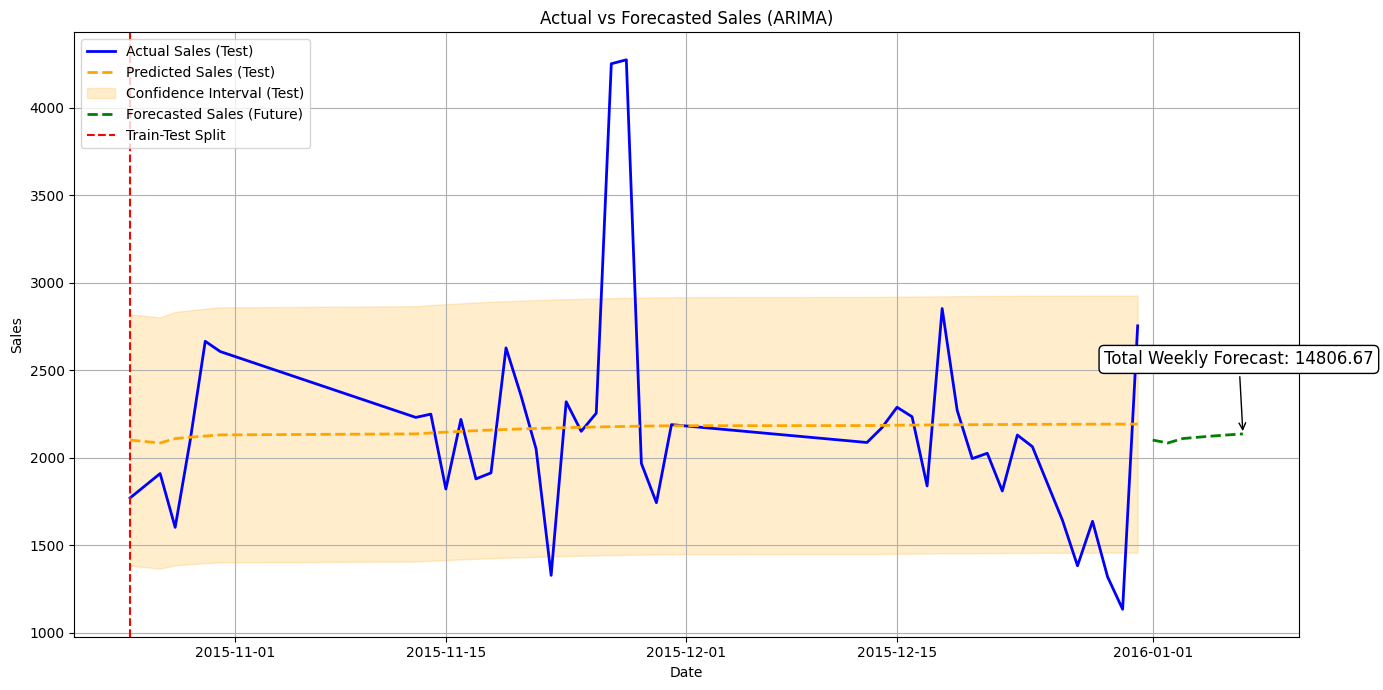

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools

# Function to calculate MAPE

def mape(actual, predicted):
   """Calculate Mean Absolute Percentage Error."""
   actual = np.where(actual == 0, 1e-6, actual)  # Avoid division by zero
   return np.mean(np.abs((actual - predicted) / actual)) * 100

def test_stationarity(series):
   """Perform Augmented Dickey-Fuller test on cleaned data."""
   series = series.dropna()
   if not np.isfinite(series).all():
       print("Series contains invalid values (NaN or inf). Please clean the data.")
       return
   result = adfuller(series)
   print(f"ADF Statistic: {result[0]:.4f}")
   print(f"p-value: {result[1]:.4f}")
   if result[1] > 0.05:
       print("The series is NOT stationary. Differencing is needed.")
   else:
       print("The series is stationary.")

# Check stationarity
print("Testing stationarity of original series:")
test_stationarity(daily_sales['daily_sales'])

# Split data into training and testing sets
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# Grid search for ARIMA parameters
p_values, d_values, q_values = range(0, 5), range(0, 3), range(0, 5)
best_score = float("inf")
best_order = None
best_model = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train['daily_sales'], order=(p, d, q))
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
        error = mape(test['daily_sales'], predictions)
        if error < best_score:
            best_score = error
            best_order = (p, d, q)
            best_model = model_fit
    except Exception as e:
        continue

print(f"Best ARIMA Order: {best_order}")
print(f"Best MAPE: {best_score:.4f}")

# Forecasting future sales
forecast_steps = 7
forecast = best_model.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=daily_sales['order_date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Sales': forecast
})

total_forecasted_sales = forecast_df['Forecasted Sales'].sum()
print("\nDay-by-Day Forecasted Sales for the Next Week:")
print(forecast_df)
print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales:.2f}")

# Plotting actual vs forecasted sales
plt.figure(figsize=(14, 7))

# Plot actual sales for the test period
plt.plot(test['order_date'], test['daily_sales'], label='Actual Sales (Test)', color='blue', linestyle='-', linewidth=2)

# Plot predicted sales for the test period
predicted_sales = best_model.forecast(steps=len(test))
plt.plot(test['order_date'], predicted_sales, label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)

# Confidence intervals
forecast_results = best_model.get_forecast(steps=len(test))
conf_int = forecast_results.conf_int()
plt.fill_between(test['order_date'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval (Test)')

# Plot future forecasts
plt.plot(forecast_df['Date'], forecast_df['Forecasted Sales'], label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)

# Annotate total weekly forecast
plt.annotate(
    f"Total Weekly Forecast: {total_forecasted_sales:.2f}",
    xy=(forecast_df['Date'].iloc[-1], forecast_df['Forecasted Sales'].iloc[-1]),
    xytext=(-100, 50),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# Highlight train-test split
plt.axvline(x=test['order_date'].iloc[0], color='red', linestyle='--', label='Train-Test Split')

# Formatting
plt.title('Actual vs Forecasted Sales (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


SARIMA Model

Testing stationarity of original series:
ADF Statistic: -7.909406451540381
p-value: 3.985243878539824e-12
Series is stationary (reject H0)
Best SARIMA Order: (0, 0, 0, 0, 0, 1)

Evaluation Metrics:
MAE: 474.4428
RMSE: 677.1540
MAPE: 3.6691
Day-by-Day Forecasted Sales for the Next Week:
    order_date  forecasted_sales
167 2016-01-01       1918.031251
168 2016-01-02       3120.370177
169 2016-01-03       1906.353899
170 2016-01-04       1784.389514
171 2016-01-05       1903.277848
172 2016-01-06       1529.477171
173 2016-01-07       1983.611774

Total Forecasted Sales for the Week: 14145.51


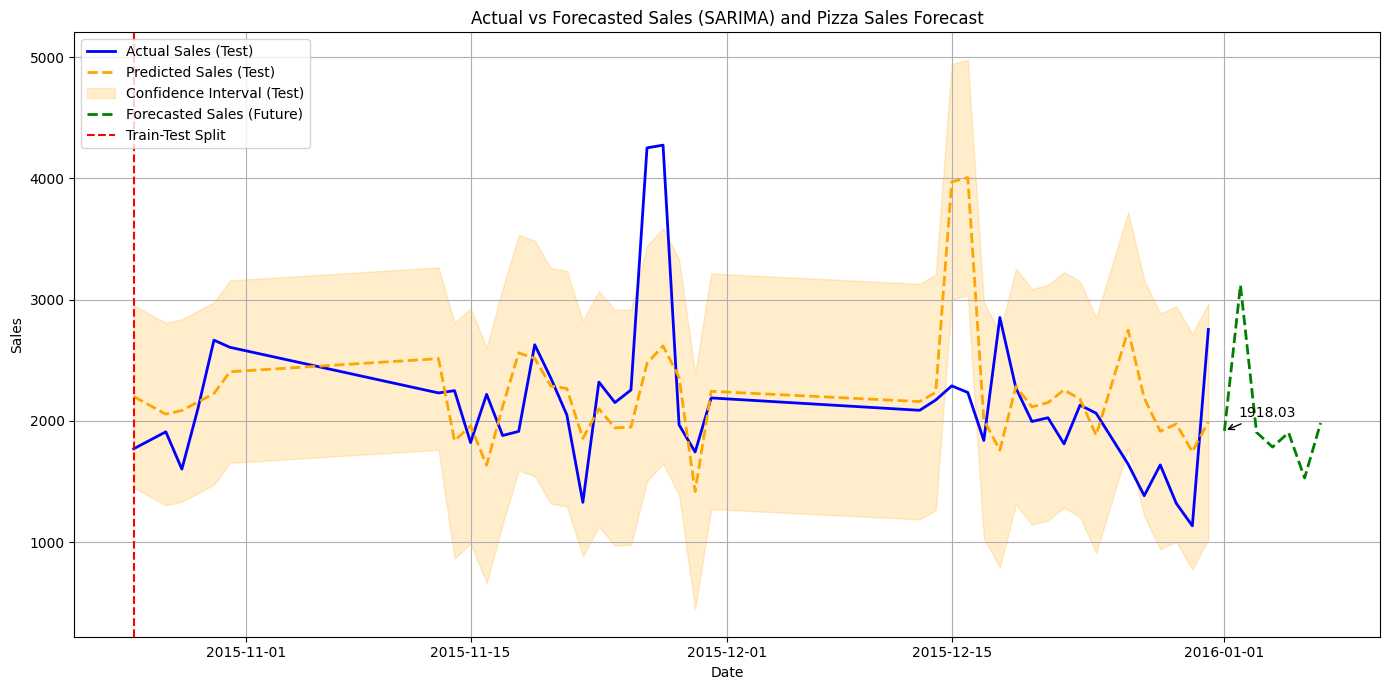

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import pickle

# Define MAPE function
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100

# Function to test for stationarity
def test_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary (reject H0)")
    else:
        print("Series is non-stationary (fail to reject H0)")

# Test for stationarity
print("Testing stationarity of original series:")
test_stationarity(daily_sales['daily_sales'])

# Split data into training and testing sets
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# SARIMA: Seasonal ARIMA Model
best_score = float("inf")
best_order = None
best_model = None
tuning_results = []  # To store hyperparameter tuning results

# Try different combinations of p, d, q, P, D, Q (seasonal order)
for p, d, q, P, D, Q in itertools.product(range(0, 4), range(0, 2), range(0, 4), range(0, 2), range(0, 2), range(0, 4)):
    try:
        model = SARIMAX(train['daily_sales'], 
                        exog=train[['is_holiday', 'lag_1', 'lag_7']], 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, 7),  # Weekly seasonality
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        predictions = model_fit.forecast(steps=len(test), exog=test[['is_holiday', 'lag_1', 'lag_7']])
        error = mape(test['daily_sales'], predictions)
        
        # Save hyperparameter tuning result
        tuning_results.append({
            'order': (p, d, q, P, D, Q),
            'mape': error
        })
        
        if error < best_score:
            best_score = error
            best_order = (p, d, q, P, D, Q)
            best_model = model_fit
    except Exception as e:
        print(f"SARIMAX({p}, {d}, {q}, {P}, {D}, {Q}) failed: {e}")
        continue

# Print best SARIMA parameters and MAPE
print(f"Best SARIMA Order: {best_order}")

# Assign the best model to sarima_best_model for clarity
sarima_best_model = best_model

# Save the hyperparameter tuning results to a CSV file
sarima_tuning_results = pd.DataFrame(tuning_results)

# Make predictions with the best model
test_predictions = sarima_best_model.forecast(steps=len(test), exog=test[['is_holiday', 'lag_1', 'lag_7']])

# Calculate MAE, MSE, RMSE, and MAPE
mae_value = mae(test['daily_sales'], test_predictions)
mse_value = mse(test['daily_sales'], test_predictions)
rmse_value = np.sqrt(mse_value)
mape_value = mape(test['daily_sales'], test_predictions)

# Print evaluation metrics
print(f"\nEvaluation Metrics:")
print(f"MAE: {mae_value:.4f}")
print(f"RMSE: {rmse_value:.4f}")
print(f"MAPE: {mape_value:.4f}")

# Forecasting
forecast_steps = 7
forecast = sarima_best_model.forecast(steps=forecast_steps, exog=test[['is_holiday', 'lag_1', 'lag_7']].tail(forecast_steps))

# Generate forecast dates
forecast_dates = pd.date_range(start=daily_sales['order_date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_df = pd.DataFrame({'order_date': forecast_dates, 'forecasted_sales': forecast})

# Total forecasted sales for the next week (sum of forecasted sales)
total_forecasted_sales_sarima = forecast_df['forecasted_sales'].sum()

# Output for Day-by-Day Forecasted Sales and Total for the Week
print("Day-by-Day Forecasted Sales for the Next Week:")
print(forecast_df)
print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales_sarima:.2f}")

# Plot actual sales for the test period
plt.figure(figsize=(14, 7))

# Plot actual sales for the test period
plt.plot(test['order_date'], test['daily_sales'], label='Actual Sales (Test)', color='blue', linestyle='-', linewidth=2)

# Plot forecasted sales for the test period
plt.plot(test['order_date'], sarima_best_model.forecast(steps=len(test), exog=test[['is_holiday', 'lag_1', 'lag_7']]), label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)

# Plot confidence intervals for the test period predictions (if available)
# Using the conf_int() function for confidence intervals
conf_int = sarima_best_model.get_forecast(steps=len(test), exog=test[['is_holiday', 'lag_1', 'lag_7']]).conf_int()
plt.fill_between(test['order_date'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval (Test)')

# Plot the forecasted sales for the future period
plt.plot(forecast_df['order_date'], forecast_df['forecasted_sales'], label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)

# Highlight the train-test split
plt.axvline(x=test['order_date'].iloc[0], color='red', linestyle='--', label='Train-Test Split')

# Annotate the first forecasted sales
plt.annotate(
    f"{forecast_df['forecasted_sales'].iloc[0]:.2f}",
    xy=(forecast_df['order_date'].iloc[0], forecast_df['forecasted_sales'].iloc[0]),
    xytext=(10, 10),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=10
)

# Formatting the plot
plt.title('Actual vs Forecasted Sales (SARIMA) and Pizza Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()



Prophet (Developed by Facebook)

01:18:34 - cmdstanpy - INFO - Chain [1] start processing
01:18:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE for Prophet: 17.7526
RMSE: 641.49
MAE: 438.15
Day-by-Day Forecasted Sales for the Next Week:
2016-01-01: 1892.05
2016-01-02: 2182.82
2016-01-03: 2374.12
2016-01-04: 2401.16
2016-01-05: 2495.08
2016-01-06: 2959.05
2016-01-07: 2495.99

Total Forecasted Sales for the Week: 16800.27


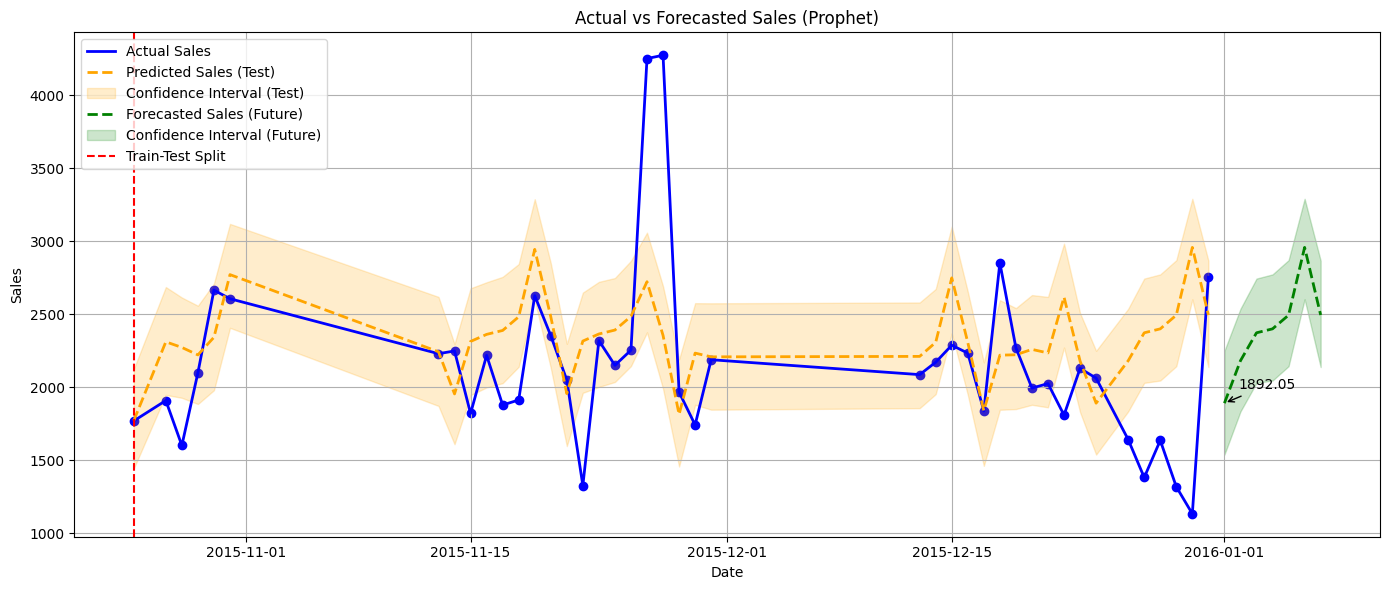

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Prepare data for Prophet (ds = date, y = sales)
prophet_data = daily_sales[['order_date', 'daily_sales', 'is_holiday', 'lag_1', 'lag_7']].rename(columns={'order_date': 'ds', 'daily_sales': 'y'})

# Normalize the external regressors for better model performance
scaler = MinMaxScaler()
prophet_data[['is_holiday', 'lag_1', 'lag_7']] = scaler.fit_transform(prophet_data[['is_holiday', 'lag_1', 'lag_7']])

# Split the data into training and testing sets
train_size = int(len(daily_sales) * 0.8)  # Assuming 80% training data
train_prophet = prophet_data[:train_size]
test_prophet = prophet_data[train_size:]

# Create and fit the Prophet model with tuned parameters
model_prophet = Prophet(
    changepoint_prior_scale=0.05,  # Reduced to avoid overfitting
    seasonality_mode='multiplicative'  # Capture proportionate seasonal variations
)
model_prophet.add_seasonality(name='weekly', period=7, fourier_order=3)
model_prophet.add_regressor('is_holiday')
model_prophet.add_regressor('lag_1')
model_prophet.add_regressor('lag_7')

# Fit the model to the training data
model_prophet.fit(train_prophet)

# Create a future dataframe for predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='D')

# Merge external regressors into the future dataframe
future = future.merge(prophet_data[['ds', 'is_holiday', 'lag_1', 'lag_7']], on='ds', how='left')
future.fillna(0, inplace=True)  

# Make predictions
forecast = model_prophet.predict(future)

# Extract predictions for the test period
forecast_test = forecast[-len(test_prophet):]

# Define evaluation metrics
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error
mape_value = mape(test_prophet['y'], forecast_test['yhat'])
rmse_value = np.sqrt(mean_squared_error(test_prophet['y'], forecast_test['yhat']))
mae_value = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])

print(f"MAPE for Prophet: {mape_value:.4f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae_value:.2f}")

# Plot actual vs predicted sales for the test period and forecasted sales for future periods
plt.figure(figsize=(14, 6))

# Plot actual sales for the test period
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Sales', color='blue', linestyle='-', linewidth=2)
plt.scatter(test_prophet['ds'], test_prophet['y'], color='blue', marker='o')  # Add markers for actual sales

# Plot predicted sales for the test period
plt.plot(test_prophet['ds'], forecast_test['yhat'], label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)

# Plot confidence intervals for test predictions
plt.fill_between(
    test_prophet['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    color='orange',
    alpha=0.2,
    label='Confidence Interval (Test)'
)

# Make predictions for the future period
forecast_steps = 7  # Set the number of future forecast steps
forecast_future = forecast[-forecast_steps:]  # Extract the future forecast

# Prepare a dataframe for future forecast
forecast_dates = pd.date_range(start=daily_sales['order_date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_df = pd.DataFrame({'order_date': forecast_dates, 'forecasted_sales': forecast_future['yhat'].values})

# Calculate the Total Forecasted Sales for the Week
total_forecasted_sales = forecast_future['yhat'].sum()

# Print day-by-day forecasted sales for the next week and the total forecasted sales for the week
print("Day-by-Day Forecasted Sales for the Next Week:")
for date, sales in zip(forecast_df['order_date'], forecast_df['forecasted_sales']):
    print(f"{date.strftime('%Y-%m-%d')}: {sales:.2f}")

print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales:.2f}")

# Plot forecasted sales for the future period
plt.plot(forecast_df['order_date'], forecast_df['forecasted_sales'], label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)

# Plot confidence intervals for the future forecast
plt.fill_between(
    forecast_df['order_date'],
    forecast_future['yhat_lower'].values,
    forecast_future['yhat_upper'].values,
    color='green',
    alpha=0.2,
    label='Confidence Interval (Future)'
)

# Highlight the train-test split
plt.axvline(x=test_prophet['ds'].iloc[0], color='red', linestyle='--', label='Train-Test Split')

# Annotate the first forecasted sales
plt.annotate(
    f"{forecast_df['forecasted_sales'].iloc[0]:.2f}",
    xy=(forecast_df['order_date'].iloc[0], forecast_df['forecasted_sales'].iloc[0]),
    xytext=(10, 10),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=10
)

# Formatting the plot
plt.title('Actual vs Forecasted Sales (Prophet)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


LSTM Model

Epoch 1/20: loss = 0.0974
Epoch 2/20: loss = 0.0364
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAPE for LSTM: 21.7397
RMSE: 653.03
MAE: 444.59

Day-by-Day Forecasted Sales for the Next Week:
2016-01-01: 2054.12
2016-01-02: 2017.97
2016-01-03: 1955.90
2016-01-04: 1933.20
2016-01-05: 1930.50
2016-01-06: 1911.47
2016-01-07: 1913.69

Total Forecasted Sales for the Week: 13716.85


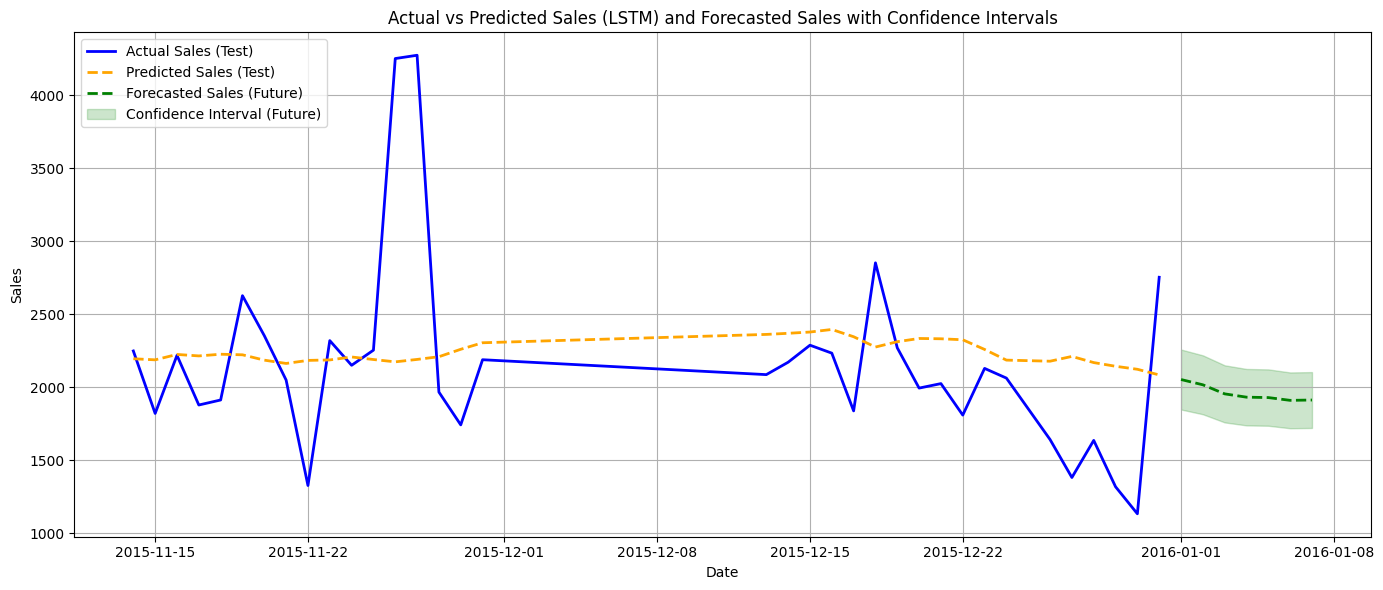

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback

# Custom callback to print first two and last two epochs
class EpochLogger(Callback):
    def __init__(self):
        self.epochs_to_print = [0, 1, -2, -1]  # First 2 and last 2 epochs
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.epochs_to_print:
            print(f"Epoch {epoch + 1}/{self.params['epochs']}: loss = {logs['loss']:.4f}")

# Prepare data for LSTM (ds = date, y = sales)
lstm_data = daily_sales[['order_date', 'daily_sales', 'is_holiday', 'lag_1', 'lag_7']].rename(columns={'order_date': 'ds', 'daily_sales': 'y'})

# Normalize the external regressors and target variable for better model performance
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lstm_data[['y', 'is_holiday', 'lag_1', 'lag_7']])

# Create the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Function to prepare sequences for LSTM
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 1:])  # Input features (all except 'y')
        y.append(data[i + time_steps, 0])    # Target variable ('y' - sales)
    return np.array(X), np.array(y)

# Prepare training and testing data
time_steps = 7  # Using 7 previous days to predict the next day

# Create sequences for training and testing
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Reshape X data to be compatible with LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for predicting 'y'

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add the custom EpochLogger callback
epoch_logger = EpochLogger()

# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, callbacks=[epoch_logger])

# Make predictions for the test period
predictions = model.predict(X_test)

# Rescale the predictions and actual values back to the original scale
predictions_rescaled = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1)))) )
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)))) )

# Extract the dates for the test period
test_dates = lstm_data['ds'].iloc[train_size + time_steps:].reset_index(drop=True)

# Evaluate the model
mape_value = np.mean(np.abs((y_test_rescaled[:, 0] - predictions_rescaled[:, 0]) / (y_test_rescaled[:, 0] + 1e-10))) * 100
rmse_value = np.sqrt(mean_squared_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0]))
mae_value = mean_absolute_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0])

# Forecasting future sales
num_future_days = 7  # Number of future days to forecast
forecasted_sales = []

# Start from the last available sequence in the test set
last_sequence = test[-time_steps:, 1:]  # Use the last time_steps from the test set

for _ in range(num_future_days):
    # Predict the next value
    next_prediction = model.predict(last_sequence[np.newaxis, :, :])  # Predict using the model
    forecasted_sales.append(next_prediction[0, 0])  # Save the predicted sales (scalar value)

    # Update the sequence with the new prediction (rolling window)
    new_entry = np.hstack((next_prediction.flatten(), last_sequence[-1, 1:]))  # Flatten next_prediction
    last_sequence = np.vstack((last_sequence[1:], new_entry))  # Shift the sequence


# Rescale forecasted sales back to original scale
forecasted_sales_rescaled = scaler.inverse_transform(
    np.hstack((np.array(forecasted_sales).reshape(-1, 1), np.zeros((len(forecasted_sales), scaled_data.shape[1] - 1)) ))
)[:, 0]

# Create future dates for the forecasted sales
last_date = pd.to_datetime(lstm_data['ds'].iloc[-1])
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, num_future_days + 1)]

# Confidence Intervals for forecasted sales
confidence_interval_lower = forecasted_sales_rescaled * 0.9  # Lower bound of confidence interval
confidence_interval_upper = forecasted_sales_rescaled * 1.1  # Upper bound of confidence interval

# Calculate total sales for the forecasted week
total_forecasted_sales = sum(forecasted_sales_rescaled)

# Day-by-day forecast for the next week
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Sales': forecasted_sales_rescaled,
    'Lower Confidence Interval': confidence_interval_lower,
    'Upper Confidence Interval': confidence_interval_upper
})

# Print MAPE, RMSE, MAE, and total sales
print(f"MAPE for LSTM: {mape_value:.4f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae_value:.2f}")

# Display day-by-day forecasted sales
print("\nDay-by-Day Forecasted Sales for the Next Week:")
for idx, row in forecast_df.iterrows():
    print(f"{row['Date'].date()}: {row['Forecasted Sales']:.2f}")

# Print total forecasted sales for the week
print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales:.2f}")

# Plot actual vs predicted sales and forecasted sales with confidence intervals
plt.figure(figsize=(14, 6))

# Plot actual sales for the test period
plt.plot(test_dates, y_test_rescaled[:, 0], label='Actual Sales (Test)', color='blue', linestyle='-', linewidth=2)

# Plot predicted sales for the test period
plt.plot(test_dates, predictions_rescaled[:, 0], label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)

# Plot forecasted sales for the future period
plt.plot(forecast_dates, forecasted_sales_rescaled, label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)

# Plot confidence intervals for the forecasted sales
plt.fill_between(forecast_dates, confidence_interval_lower, confidence_interval_upper, color='green', alpha=0.2, label='Confidence Interval (Future)')

# Formatting the plot
plt.title('Actual vs Predicted Sales (LSTM) and Forecasted Sales with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Regression Model

MAPE for Linear Regression: 19.7733
RMSE: 610.86
MAE: 405.20

Day-by-Day Forecasted Sales for the Next Week:
2016-01-01: 2160.91
2016-01-02: 1961.03
2016-01-03: 2011.38
2016-01-04: 2132.95
2016-01-05: 2099.41
2016-01-06: 2112.63
2016-01-07: 2126.13

Total Forecasted Sales for the Week: 14604.44


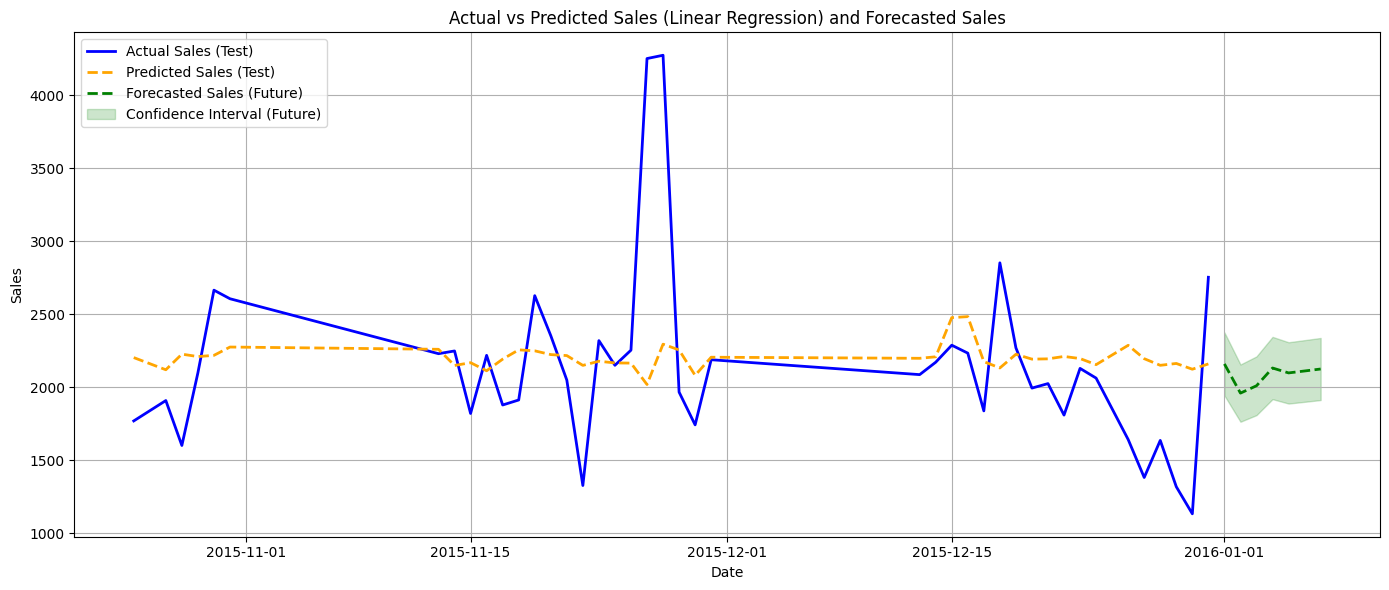

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Assuming daily_sales DataFrame exists
# Prepare data for Linear Regression (ds = date, y = sales)
lr_data = daily_sales[['order_date', 'daily_sales', 'is_holiday', 'lag_1', 'lag_7']].rename(columns={'order_date': 'ds', 'daily_sales': 'y'})

# Normalize the external regressors and target variable for consistency
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lr_data[['y', 'is_holiday', 'lag_1', 'lag_7']])

# Create the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the features (X) and target variable (y)
X_train = train[:, 1:]  # Input features (all except 'y')
y_train = train[:, 0]   # Target variable ('y' - sales)
X_test = test[:, 1:]
y_test = test[:, 0]

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Rescale predictions and actual values back to the original scale
predictions_rescaled = scaler.inverse_transform(
    np.hstack((predictions.reshape(-1, 1), np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]

# Evaluate the model
mape_value = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / (y_test_rescaled + 1e-10))) * 100
rmse_value = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mae_value = mean_absolute_error(y_test_rescaled, predictions_rescaled)

# Forecasting future sales
num_future_days = 7  # Number of future days to forecast
forecasted_sales = []

# Start from the last available row in the test set
last_row = test[-1, 1:]  # Use the last row from the test set

for _ in range(num_future_days):
    # Predict the next value
    next_prediction = model.predict(last_row.reshape(1, -1))[0]
    forecasted_sales.append(next_prediction)

    # Update the row with the new prediction (rolling window logic)
    last_row = np.array([next_prediction] + last_row[:-1].tolist())  # Shift window with the new prediction

# Rescale forecasted sales back to the original scale
forecasted_sales_rescaled = scaler.inverse_transform(
    np.hstack((np.array(forecasted_sales).reshape(-1, 1), np.zeros((len(forecasted_sales), scaled_data.shape[1] - 1))))
)[:, 0]

# Create future dates for the forecasted sales
last_date = pd.to_datetime(lr_data['ds'].iloc[-1])
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, num_future_days + 1)]

# Confidence Intervals for forecasted sales
confidence_interval_lower = forecasted_sales_rescaled * 0.9  # Lower bound of confidence interval
confidence_interval_upper = forecasted_sales_rescaled * 1.1  # Upper bound of confidence interval

# Calculate total sales for the forecasted week
total_forecasted_sales = sum(forecasted_sales_rescaled)

# Day-by-day forecast for the next week
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Sales': forecasted_sales_rescaled,
    'Lower Confidence Interval': confidence_interval_lower,
    'Upper Confidence Interval': confidence_interval_upper
})

# Print MAPE, RMSE, MAE, and total sales
print(f"MAPE for Linear Regression: {mape_value:.4f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae_value:.2f}")

# Display day-by-day forecasted sales
print("\nDay-by-Day Forecasted Sales for the Next Week:")
for idx, row in forecast_df.iterrows():
    print(f"{row['Date'].date()}: {row['Forecasted Sales']:.2f}")

# Print total forecasted sales for the week
print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales:.2f}")

# Plot actual vs predicted sales and forecasted sales with confidence intervals
plt.figure(figsize=(14, 6))

# Extract the dates for the test period
test_dates = lr_data['ds'].iloc[train_size:].reset_index(drop=True)

# Plot actual sales for the test period
plt.plot(test_dates, y_test_rescaled, label='Actual Sales (Test)', color='blue', linestyle='-', linewidth=2)

# Plot predicted sales for the test period
plt.plot(test_dates, predictions_rescaled, label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)

# Plot forecasted sales for the future period
plt.plot(forecast_dates, forecasted_sales_rescaled, label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)

# Plot confidence intervals for the forecasted sales
plt.fill_between(forecast_dates, confidence_interval_lower, confidence_interval_upper, color='green', alpha=0.2, label='Confidence Interval (Future)')

# Formatting the plot
plt.title('Actual vs Predicted Sales (Linear Regression) and Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Best model

Model Evaluation Metrics (MAPE):
        Model     MAPE
0       ARIMA  19.2229
1      SARIMA   3.6691
2     Prophet  17.7526
3        LSTM  21.8291
4  Regression  20.5615

Best Model Based on MAPE:
Model    SARIMA
MAPE     3.6691
Name: 1, dtype: object

The best model is: SARIMA


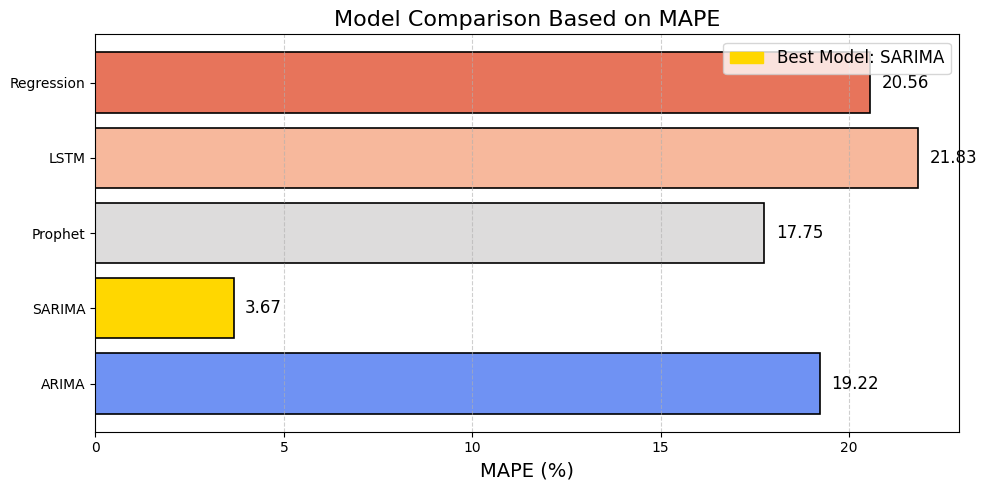

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Manually update the performance metrics for each model
results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'LSTM', 'Regression'],
    'MAPE': [19.2229, 3.6691, 17.7526, 21.8291, 20.5615]
})

# Display the results to see the metrics for each model
print("Model Evaluation Metrics (MAPE):")
print(results)

# Select the model with the lowest MAPE (best model)
best_model = results.sort_values(by='MAPE').iloc[0]

# Print the best model based on MAPE
print("\nBest Model Based on MAPE:")
print(best_model)

# Output the name of the best model
best_model_name = best_model['Model']
print(f"\nThe best model is: {best_model_name}")

# Visualization: Plotting the MAPE values for each model
plt.figure(figsize=(10, 5))

# Set a color palette with Seaborn's 'coolwarm' to emphasize the best model
color_map = sns.color_palette("coolwarm", len(results))  # A palette that ranges from blue (low) to red (high)

# Plotting the horizontal bar chart
bars = plt.barh(results['Model'], results['MAPE'], color=color_map)

# Add a title and labels with better font sizes
plt.xlabel('MAPE (%)', fontsize=14)
plt.title('Model Comparison Based on MAPE', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate the MAPE values on the bars with custom positioning
for index, value in enumerate(results['MAPE']):
    plt.text(value + 0.3, index, f'{value:.2f}', va='center', fontsize=12, color='black')

# Highlight the best model bar in a unique color (golden yellow) to make it stand out
best_model_index = results[results['Model'] == best_model_name].index[0]  # Get index of the best model
bars[best_model_index].set_color('gold')  # Highlight the best model's bar in gold

# Add a Legend and annotate the best model
plt.legend([bars[best_model_index]], ['Best Model: ' + best_model_name], loc='upper right', fontsize=12)

# Adding a border around the bars for contrast
for bar in bars:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.2)

# Display the plot with improved layout
plt.tight_layout()
plt.show()


In [261]:
print("\nSARIMA Model Summary:")
print(sarima_best_model.summary())



SARIMA Model Summary:
                                 SARIMAX Results                                 
Dep. Variable:               daily_sales   No. Observations:                  167
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood               -1174.904
Date:                   Sun, 08 Dec 2024   AIC                           2359.809
Time:                           01:18:39   BIC                           2375.153
Sample:                                0   HQIC                          2366.040
                                   - 167                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday  -106.2014    278.090     -0.382      0.703    -651.247     438.844
lag_1          0.1376      0.086      1.594      0.111      -0.032       0.307
lag_7

In [262]:
print("\nsarima_tuning_results Summary:")
print(sarima_tuning_results)


sarima_tuning_results Summary:
                  order       mape
0    (0, 0, 0, 0, 0, 0)  11.514078
1    (0, 0, 0, 0, 0, 1)   3.669115
2    (0, 0, 0, 0, 0, 2)   4.338691
3    (0, 0, 0, 0, 0, 3)   4.693432
4    (0, 0, 0, 0, 1, 0)  24.859767
..                  ...        ...
507  (3, 1, 3, 1, 0, 3)  21.820620
508  (3, 1, 3, 1, 1, 0)  23.332518
509  (3, 1, 3, 1, 1, 1)  14.716778
510  (3, 1, 3, 1, 1, 2)  23.932913
511  (3, 1, 3, 1, 1, 3)  22.459962

[512 rows x 2 columns]


In [263]:
import pickle

with open("best_sarima_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
    print("\nsaved to 'best_sarima_model.pkl'.")



saved to 'best_sarima_model.pkl'.


In [264]:
import pickle

# Assuming 'model' is your trained SARIMA model (e.g., results from SARIMAX.fit())
with open('best_sarima_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [275]:
pizza_ingredients.head(10)

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0
5,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecue Sauce,15.0
6,bbq_ckn_m,The Barbecue Chicken Pizza,Barbecued Chicken,30.0
7,bbq_ckn_m,The Barbecue Chicken Pizza,Red Peppers,10.0
8,bbq_ckn_m,The Barbecue Chicken Pizza,Green Peppers,15.0
9,bbq_ckn_m,The Barbecue Chicken Pizza,Tomatoes,20.0


In [266]:
pizza_ingredients.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

In [ ]:
total_forecasted_sales_sarima = 1000  # Replace this with the actual value

# Calculate the total sales for all pizzas in your pizza_ingredients DataFrame
total_pizza_sales = pizza_ingredients['Items_Qty_In_Grams'].sum()

# Create a dictionary to store the forecasted sales per pizza, distributing the total forecasted sales
forecasted_sales_dict = {}
for _, row in pizza_ingredients.iterrows():
    pizza_sales_proportion = row['Items_Qty_In_Grams'] / total_pizza_sales
    forecasted_sales_dict[row['pizza_name_id']] = total_forecasted_sales_sarima * pizza_sales_proportion

# Now map the forecasted sales to the pizza_ingredients DataFrame
ingredients_predicted = pizza_ingredients.copy()

# Map forecasted sales to each pizza
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(forecasted_sales_dict)

# Calculate total ingredient quantity
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Calculate ingredient totals across pizzas
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()

# Display ingredient totals
print("Total ingredient requirements based on forecasted sales:")
print(ingredient_totals)


Total ingredient requirements based on forecasted sales:
{'?duja Salami': 88.60198721599899, 'Alfredo Sauce': 45.88317195114233, 'Anchovies': 61.70495538257072, 'Artichokes': 411.36636921713813, 'Arugula': 44.300993607999494, 'Asiago Cheese': 196.19011454971204, 'Bacon': 2177.0774001645464, 'Barbecue Sauce': 22.150496803999747, 'Barbecued Chicken': 63.28713372571356, 'Beef Chuck Roast': 2645.402189734827, 'Blue Cheese': 28.4792101765711, 'Brie Carre Cheese': 9.493070058857034, 'Calabrese Salami': 221.50496803999746, 'Capocollo': 886.0198721599899, 'Caramelized Onions': 5.062970698057085, 'Chicken': 2088.4754129485477, 'Chipotle Sauce': 132.9029808239985, 'Chorizo Sausage': 158.21783431428392, 'Cilantro': 66.45149041199925, 'Coarse Sicilian Salami': 177.20397443199798, 'Corn': 446.1742927662806, 'Eggplant': 177.20397443199798, 'Feta Cheese': 1427.1248655148408, 'Fontina Cheese': 132.9029808239985, 'Friggitello Peppers': 22.150496803999747, 'Garlic': 849.6297702677045, 'Genoa Salami': 13

In [269]:
import pandas as pd

# Convert the ingredient_totals dictionary into a DataFrame
ingredient_totals_df = pd.DataFrame(list(ingredient_totals.items()), columns=['Ingredient', 'Total_Quantity in Grams'])

# Display the DataFrame
print(ingredient_totals_df)


                 Ingredient  Total_Quantity in Grams
0              ?duja Salami                88.601987
1             Alfredo Sauce                45.883172
2                 Anchovies                61.704955
3                Artichokes               411.366369
4                   Arugula                44.300994
..                      ...                      ...
59       Sun-dried Tomatoes               132.902981
60  Thai Sweet Chilli Sauce                88.601987
61                    Thyme                 1.582178
62                 Tomatoes              1778.368458
63                 Zucchini               132.902981

[64 rows x 2 columns]


In [276]:
total_pizza_sales = pizza_ingredients['Items_Qty_In_Grams'].sum()
print(f"Total pizza sales (sum of all ingredients in grams): {total_pizza_sales}")


Total pizza sales (sum of all ingredients in grams): 15801.0


In [280]:
# Check the total ingredient quantity for the first few rows
print("Total ingredient quantity for some pizzas:")
print(ingredients_predicted[['pizza_name_id', 'predicted_quantity', 'total_ingredient_qty']].head(50))


Total ingredient quantity for some pizzas:
   pizza_name_id  predicted_quantity  total_ingredient_qty
0      bbq_ckn_l            0.949307             37.972280
1      bbq_ckn_l            0.949307             14.239605
2      bbq_ckn_l            0.949307             18.986140
3      bbq_ckn_l            0.949307             28.479210
4      bbq_ckn_l            0.949307             56.958420
5      bbq_ckn_l            0.949307             14.239605
6      bbq_ckn_m            0.632871             18.986140
7      bbq_ckn_m            0.632871              6.328713
8      bbq_ckn_m            0.632871              9.493070
9      bbq_ckn_m            0.632871             12.657427
10     bbq_ckn_m            0.632871             25.314853
11     bbq_ckn_m            0.632871              6.328713
12     bbq_ckn_s            0.316436              6.328713
13     bbq_ckn_s            0.316436              1.582178
14     bbq_ckn_s            0.316436              6.328713
15     bbq_ck

In [281]:
# Print the top ingredients with the highest total requirements
print("Top ingredients by total quantity required:")
print(sorted(ingredient_totals.items(), key=lambda x: x[1], reverse=True)[:10])


Top ingredients by total quantity required:
[('Red Onions', 3620.0240491108157), ('Beef Chuck Roast', 2645.402189734827), ('Bacon', 2177.0774001645464), ('Chicken', 2088.4754129485477), ('Tomatoes', 1778.3684576925511), ('Pepperoni', 1689.766470476552), ('Mushrooms', 1518.8912094171255), ('Feta Cheese', 1427.1248655148408), ('Spinach', 1091.703056768559), ('Capocollo', 886.0198721599899)]


In [282]:
# Forecasting sales for the next 7 days
ingredients_predicted['weekly_forecasted_sales'] = ingredients_predicted['predicted_quantity'] * 7
print("Pizza-wise forecast for the next 7 days:")
print(ingredients_predicted[['pizza_name_id', 'predicted_quantity', 'weekly_forecasted_sales']].head())


Pizza-wise forecast for the next 7 days:
  pizza_name_id  predicted_quantity  weekly_forecasted_sales
0     bbq_ckn_l            0.949307                 6.645149
1     bbq_ckn_l            0.949307                 6.645149
2     bbq_ckn_l            0.949307                 6.645149
3     bbq_ckn_l            0.949307                 6.645149
4     bbq_ckn_l            0.949307                 6.645149


In [283]:
total_weekly_sales = ingredients_predicted['weekly_forecasted_sales'].sum()
print(f"Total forecasted sales for the week: {total_weekly_sales}")


Total forecasted sales for the week: 4797.7976077463445


In [284]:
weekly_ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum()
print("Weekly ingredient totals for the next 7 days:")
print(weekly_ingredient_totals)


Weekly ingredient totals for the next 7 days:
pizza_ingredients
?duja Salami                 88.601987
Alfredo Sauce                45.883172
Anchovies                    61.704955
Artichokes                  411.366369
Arugula                      44.300994
                              ...     
Sun-dried Tomatoes          132.902981
Thai Sweet Chilli Sauce      88.601987
Thyme                         1.582178
Tomatoes                   1778.368458
Zucchini                    132.902981
Name: total_ingredient_qty, Length: 64, dtype: float64
